In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("ksi_collisions.csv")

In [3]:
df.sample(2)

,DATE,STREET1,STREET2,DISTRICT,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,ROAD_CONDITION,ACCLASS,...,DOW,HOUR,YEAR,MONTH,SEVERE_COLLISION,TIME_OF_DAY,SEASON,VEHICLE_TYPE,DRIVER_ACTION,IMPACT_TYPE
16182,2020-06-09,DUFFERIN ST,BLOOR ST W,Toronto and East York,43.659812,-79.435321,Clear,Dark,Dry,Non-Fatal Injury,...,Tuesday,21,2020,6,0,Night,Summer,Car,Other/Unknown,Pedestrian/Cyclist
9692,2013-08-13,STEELES AVE E,MIDDLEFIELD RD,Scarborough,43.832644,-79.267993,Clear,Daylight,Dry,Fatal,...,Tuesday,11,2013,8,1,MorningAfternoon,Summer,Car,Other/Unknown,Pedestrian/Cyclist


In [4]:
categorical_features = ['LIGHT', 'VISIBILITY', 'ROAD_CONDITION', 'DOW', 'TIME_OF_DAY',
                        'SEASON', 'VEHICLE_TYPE', 'DRIVER_ACTION', 'IMPACT_TYPE', 'NEIGHBOURHOOD']

In [5]:
target = 'SEVERE_COLLISION'

In [6]:
X = df[categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=15,
        max_depth=14,
        max_features = 'sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [8]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1923
           1       0.66      0.65      0.65      1797

    accuracy                           0.67      3720
   macro avg       0.67      0.67      0.67      3720
weighted avg       0.67      0.67      0.67      3720



In [10]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

Train accuracy: 0.706
Test accuracy: 0.667


In [11]:
sample = {
    'LIGHT': 'Daylight',
    'VISIBILITY': 'Clear',
    'ROAD_CONDITION': 'Dry',
    'DOW': 'Friday',
    'TIME_OF_DAY': 'Evening',
    'SEASON': 'S',
    'VEHICLE_TYPE': 'Car',
    'DRIVER_ACTION': 'Failed to Yield Right of Way',
    'IMPACT_TYPE': 'T-Bone',
    'NEIGHBOURHOOD': 'Woodbine-Lumsden'
}

sample_df = pd.DataFrame([sample])

In [12]:
prediction = model.predict(sample_df)[0]
probability = model.predict_proba(sample_df)[0][1]
print(f"Predicted class: {prediction} (1 = Severe, 0 = Not Severe)")
print(f"Probability of severe collision: {probability:.3f}")

Predicted class: 0 (1 = Severe, 0 = Not Severe)
Probability of severe collision: 0.356


In [13]:
valid_categories = {
    col: set(X_train[col].dropna().unique())
    for col in categorical_features
}

print(valid_categories)

{'LIGHT': {'Twilight', 'Daylight', 'Dark'}, 'VISIBILITY': {'Clear', 'Snow', 'Rain'}, 'ROAD_CONDITION': {'SnowIce', 'Dry', 'Wet'}, 'DOW': {'Sunday', 'Friday', 'Tuesday', 'Wednesday', 'Monday', 'Saturday', 'Thursday'}, 'TIME_OF_DAY': {'Night', 'MorningAfternoon', 'LateNight', 'Evening'}, 'SEASON': {'Spring', 'Fall', 'Winter', 'Summer'}, 'VEHICLE_TYPE': {'Emergency', 'Car', 'Two Wheeler', 'Truck', 'Bus'}, 'DRIVER_ACTION': {'Speed-Related', 'Right-of-Way/Traffic Violation', 'Control/Maneuver Error', 'Other/Unknown'}, 'IMPACT_TYPE': {'Slow/Parked', 'T-Bone', 'Sideswipe/Approaching', 'Pedestrian/Cyclist', 'Rear End'}, 'NEIGHBOURHOOD': {'Pelmo Park-Humberlea', 'Rexdale-Kipling', 'Morningside Heights', 'Cabbagetown-South St.James Town', 'Steeles', 'Newtonbrook West', 'Agincourt South-Malvern West', 'Willowridge-Martingrove-Richview', 'Humber Heights-Westmount', 'Lawrence Park South', 'Wychwood', 'Annex', 'Keelesdale-Eglinton West', 'Humber Summit', 'Casa Loma', 'West Humber-Clairville', 'Westo

In [14]:
#save model
joblib.dump({
    "model": model,
    "valid_categories": valid_categories
}, "model.joblib")

['model.joblib']

In [15]:
y_proba = model.predict_proba(df)[:, 1]

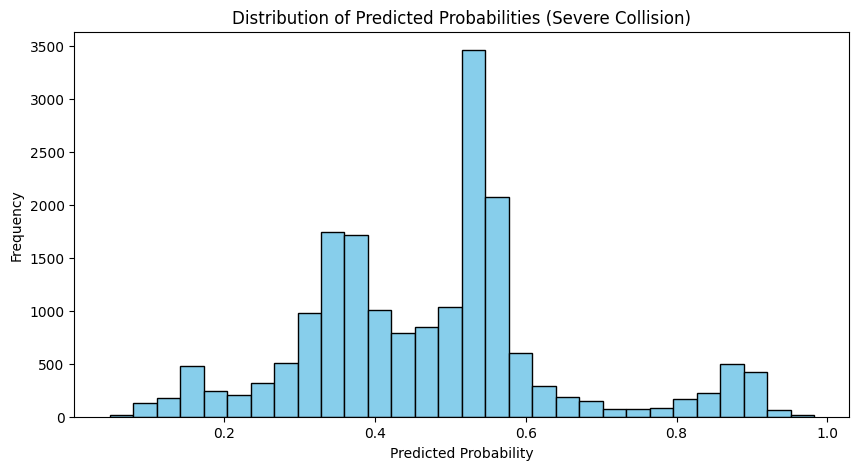

In [16]:
plt.figure(figsize=(10,5))
plt.hist(y_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Severe Collision)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

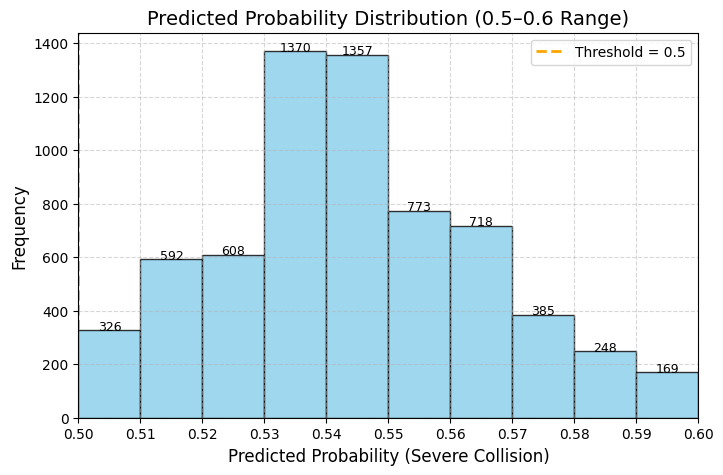

In [17]:
bins = np.arange(0.5, 0.61, 0.01)

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(
    y_proba, bins=bins, color='skyblue', edgecolor='black', alpha=0.8
)

plt.title("Predicted Probability Distribution (0.5–0.6 Range)", fontsize=14)
plt.xlabel("Predicted Probability (Severe Collision)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for i, count in enumerate(counts):
    plt.text(bins[i] + 0.005, count + 0.5, str(int(count)), ha='center', fontsize=9)

plt.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.5')

plt.xlim(0.5, 0.6)
plt.xticks(np.arange(0.5, 0.61, 0.01))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()